# Assignment 2

In [101]:
#import statements
import pandas as pd
import numpy as np
import keras
import nltk
from nltk.tokenize import word_tokenize
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing required functions from keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras import layers
import keras.backend as K

#importing libraries required for preprocessing
import re
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth', -1)
from sklearn.model_selection import train_test_split

# importing the required util function
import functions.utils
from functions.utils import *
from functions.utils import clean_text
from functions.utils import load_embedding, create_embedding_weights, max_seq_len
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam
import functions.model_evaluation
from functions.model_evaluation import *

import functions.data_manipulation
from functions.data_manipulation import *

#importing the module which has all the deeplearning models
import models.models as models

<p><font size = 3> Loading the required data sets from the specified URLs</p>

In [2]:
# loading datasets
train = pd.read_csv('data/train.txt', delimiter = '\t')
test = pd.read_csv('data/test.txt', delimiter = '\t')
trial = pd.read_csv('data/trial.txt', delimiter = '\t')
test_ann = pd.read_csv('data/test_anno.txt', delimiter = '\t')

## Data Preprocessing

<p><font size = 3> The data preprocessing consists of different steps</p>
    <ul> <li>Data cleaning: Expansion of contractions and removal of special charecters</li>
        <li> Loadin pre-trained word embbeding: Glove word embedding was used to create embedding matrics</li>
        <li> tokenizing and Word embedding:Input data was tokenized and the converted to sequences and then padded a pre-trained word embedding was used to represent the weights</li>
        </ul>

### Data cleaning
<p><font size = 3> For cleaning the data clean_text(text), a UDF which takes a text input and expands the contractions and removes special charecters, the function definition can be found in the utils.py file 

In [3]:
#Cleaning the data
train['sentence_A'] = train['sentence_A'].apply(clean_text)
train['sentence_B'] = train['sentence_B'].apply(clean_text)
test['sentence_A'] = test['sentence_A'].apply(clean_text)
test['sentence_B'] = test['sentence_B'].apply(clean_text)
trial['sentence_A'] = trial['sentence_A'].apply(clean_text)
trial['sentence_B'] = trial['sentence_B'].apply(clean_text)

<p><font size =3> Encoding the class values: For encoding the class values the LabelEncoder() from scipy was used, it converts the class values to numbers

In [4]:
#encoding the target feature
lbl_enc = LabelEncoder()
train['entailment_encoded'] = lbl_enc.fit_transform(train['entailment_judgment'])
trial['entailment_encoded'] = lbl_enc.fit_transform(trial['entailment_judgment'])
############################For now############################################
test_ann['entailment_encoded'] = lbl_enc.fit_transform(test_ann['entailment_judgment'])

### Tokenizing and embedding matrix

<p><font size = 3> Creating the word embedding dictionary from a pretrained word embedding: The load embedding function loads a pretrained word embedding from a text file and creates a dictionary, with key as the word and word vector as value

In [5]:
file_name = 'word_embeddings/glove.6B.300d.txt'
embeddings = load_embedding(file_name)

<p> <font size = 3> Tokenizing the sentences and creating a sequence from the tokens: For Tokenizing the sentences Tokenizer() from keras was used, once the sentences were tokenized, text_to_sequence() function converts the tokens to sequence

In [6]:
NUM_WORDS = len(embeddings) #200000
sentences = (list(train['sentence_A']) + list(train['sentence_B']) + 
                       list(test['sentence_A']) + list(test['sentence_B'])+ 
                           list(trial['sentence_A']) + list(trial['sentence_B']))
tokenize = Tokenizer(num_words = NUM_WORDS)
tokenize.fit_on_texts(sentences)
sent1_word_seq = tokenize.texts_to_sequences(train['sentence_A'])
sent2_word_seq = tokenize.texts_to_sequences(train['sentence_B'])
sent1_word_seq_test = tokenize.texts_to_sequences(test['sentence_A'])
sent2_word_seq_test = tokenize.texts_to_sequences(test['sentence_B'])
sent1_word_seq_trial = tokenize.texts_to_sequences(trial['sentence_A'])
sent2_word_seq_trial = tokenize.texts_to_sequences(trial['sentence_B'])
word_index = tokenize.word_index

<p> <font size = 3> The create_embedding_weights() function creates  embedding weights matrix using the word embedding and the idexes of the corresponding words using the index of the sequences

In [7]:
#Matrix with the embedding weights
embedding_dim = 300
embedding_weights = create_embedding_weights(embeddings, embedding_dim, word_index, NUM_WORDS)

<p> <font size = 3> The max_seq_len(fuction) returns the maximum sequence length from the list of the sequences

In [8]:
# extracting the maximum sequence length
max_seq_length = max_seq_len(sent1_word_seq)
max_seq_length = max_seq_len(sent2_word_seq, max_seq_length)
max_seq_length = max_seq_len(sent1_word_seq_test, max_seq_length)
max_seq_length = max_seq_len(sent2_word_seq_test, max_seq_length)
max_seq_length = max_seq_len(sent1_word_seq_trial, max_seq_length)
max_seq_length = max_seq_len(sent2_word_seq_trial, max_seq_length)

<p> <font size = 3> As the sequences where in different lengths the sequences were padded to the maximum sequence length using the pad_sequences method

In [9]:
# padding the sequences
sent1_data = pad_sequences(sent1_word_seq, maxlen = max_seq_length)
sent2_data = pad_sequences(sent2_word_seq, maxlen = max_seq_length)

sent1_data_trial = pad_sequences(sent1_word_seq_trial, maxlen = max_seq_length)
sent2_data_trial = pad_sequences(sent2_word_seq_trial, maxlen = max_seq_length)

sent1_data_test = pad_sequences(sent1_word_seq_test, maxlen = max_seq_length)
sent2_data_test = pad_sequences(sent2_word_seq_test, maxlen = max_seq_length)

In [10]:
NUM_WORDS = len(embedding_weights)
NUM_WORDS

2307

<p> <font size = 4> to_categorical() function converts the numerical classes to binary columns

In [11]:
labels = to_categorical(np.asarray(train['entailment_encoded']))
labels2 = to_categorical(np.asarray(trial['entailment_encoded']))

## Deep learning models

### 1) Siamese LSTM network
<p> <font size = 3> intializing the varibles required to train the deep learning model</p>
    <ul>
        <li> batch_size: batch size after which the weights are updated using Stochastic gradient descent</li>
        <li> epochs: The number of iterations</li>
        <li> validation_split: the percent of data from training data that needs to be used for validation            

In [153]:
# number of iterations, batch_size and validation split for the model
batch_size = 10
epochs = 15
#validation_split = .1

<p><font size =3> Model class contains the list models that can be used for classifying the entailment, the parameters are:
    <ul>
        <li>embedding_dim: Dimensions of the word embedding</li>
        <li>NUM_WORDS: number of words in the data set</li>
        <li>max_seq_length: max sequence length in the data set</li>
        <li>dropout: dropout percentage to reduce overfitting</li>
        </ul>

In [154]:
#laoding the module from deep learning models
import models.models as models

m1 = models.models(embedding_dim,
                   NUM_WORDS, 
                   embedding_weights,
#                   dropout = .1,
#                   l2_reg = .0001
                   max_seq_length,
                  )

<p><font size = 3> simaese_lstm model

In [155]:
model = m1.siames()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 32, 300)      692100      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300)          721200      embedding_17[0][0]        

<p> <font size = 3> training the model: sent1_data will be passed to the first networks and sent2_data will be passed to the second network

In [156]:
hist = model.fit([sent1_data, sent2_data], labels, batch_size = 10, 
                 epochs = 15,
                 validation_data= ([sent1_data_trial, sent2_data_trial],labels2 ))

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 81s 18ms/step - loss: 0.7639 - accuracy: 0.6307 - val_loss: 0.6420 - val_accuracy: 0.6940
Epoch 2/15
4500/4500 [==============================] - 81s 18ms/step - loss: 0.5393 - accuracy: 0.7702 - val_loss: 0.5312 - val_accuracy: 0.7900
Epoch 3/15
4500/4500 [==============================] - 80s 18ms/step - loss: 0.4249 - accuracy: 0.8273 - val_loss: 0.4788 - val_accuracy: 0.8280
Epoch 4/15
4500/4500 [==============================] - 81s 18ms/step - loss: 0.3268 - accuracy: 0.8813 - val_loss: 0.4705 - val_accuracy: 0.8200: 25s - -  - ETA
Epoch 5/15
4500/4500 [==============================] - 84s 19ms/step - loss: 0.2632 - accuracy: 0.9058 - val_loss: 0.4327 - val_accuracy: 0.8180
Epoch 6/15
4500/4500 [==============================] - 80s 18ms/step - loss: 0.1903 - accuracy: 0.9387 - val_loss: 0.5383 - val_accuracy: 0.8080
Epoch 7/15
4500/4500 [==============================] - 80s 1

#### Model Evaluation

<p> <font size =3> <ul>
    <li>Training accuracy and validation accuracy after each iteration</li>
    <li>Training loss and validation loss after each iteration 

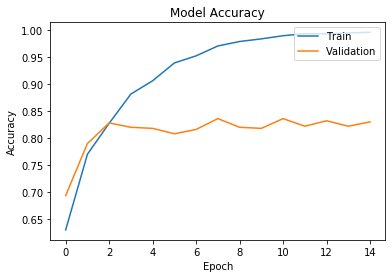

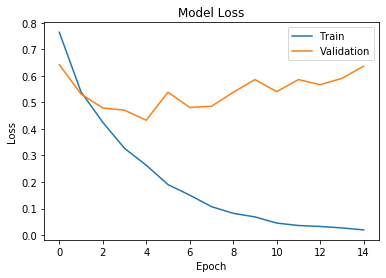

In [166]:
plot_model_training(hist)

#### accuracy

<p> <font size = 3> Calculating the accuracy of the predicted classes

In [167]:
siamese_lstm_model = model

In [168]:
k = siamese_lstm_model.predict([sent1_data_test, sent2_data_test])

In [169]:
result = convert_prob(k)

In [170]:
prec, rec, f1_s, acc = evaluate_model(test_ann['entailment_encoded'], result)

In [171]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 score: "+ str(f1_s))
print("Accuracy: "+ str(acc*100)+"%")

Precision: 0.8298788907676514
Recall: 0.8246397402070226
F1 score: 0.825883248816789
Accuracy: 82.46397402070225%


In [175]:
siamese_df = map_entailment(lbl_enc, result, test)

C:\Users\hkpat\Masters\NLP\Assignment2_final\submission\functions\data_manipulation.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['entailment_judgment'] =  entailment_result


In [177]:
siamese_df.head()

,pair_ID,entailment_judgment
0,6,NEUTRAL
1,7,NEUTRAL
2,8,NEUTRAL
3,10,ENTAILMENT
4,11,ENTAILMENT


In [178]:
output_csv(siamese_df, "entailment_relatedness/entailment/siamese_lstm_entailment.csv", index = False)

## 2) siamese_cnn
<p><font size = 3> Siamese CNN, two individual CNN networks are used for both the sentences and are merged taking the absolute difference, this value is passed to an output Dense sigmoid, which outputs 3 values. The three values are the probilites of the entailment, finally the value with the maximum probability is taken as the prediction.

In [13]:
import models.models as models

m1 = models.models(embedding_dim,
                   NUM_WORDS, 
                   embedding_weights,
                   max_seq_length,
                  dropout=.1)
model = m1.cnn()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 250)          731550      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 250)          0           sequential_1[1][0]         

In [14]:
import models.models as models
m1 = models.models(embedding_dim,
                   NUM_WORDS, 
                   embedding_weights,
                   max_seq_length,
                  dropout=.1)

In [15]:
hist = model.fit([sent1_data, sent2_data], labels, batch_size = 32, 
                 epochs = 15,
                 validation_data= ([sent1_data_trial, sent2_data_trial],labels2 ))

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 4s 819us/step - loss: 0.5631 - accuracy: 0.7103 - val_loss: 0.5566 - val_accuracy: 0.7293
Epoch 2/15
4500/4500 [==============================] - 4s 809us/step - loss: 0.5419 - accuracy: 0.7193 - val_loss: 0.5479 - val_accuracy: 0.7353
Epoch 3/15
4500/4500 [==============================] - 3s 768us/step - loss: 0.5314 - accuracy: 0.7306 - val_loss: 0.5432 - val_accuracy: 0.7300
Epoch 4/15
4500/4500 [==============================] - 3s 756us/step - loss: 0.5192 - accuracy: 0.7370 - val_loss: 0.5265 - val_accuracy: 0.7333
Epoch 5/15
4500/4500 [==============================] - 4s 789us/step - loss: 0.4973 - accuracy: 0.7476 - val_loss: 0.5008 - val_accuracy: 0.7640
Epoch 6/15
4500/4500 [==============================] - 3s 745us/step - loss: 0.4458 - accuracy: 0.7719 - val_loss: 0.4662 - val_accuracy: 0.7740
Epoch 7/15
4500/4500 [==============================] - 3s 758us/step - loss:

#### Model Evaluation

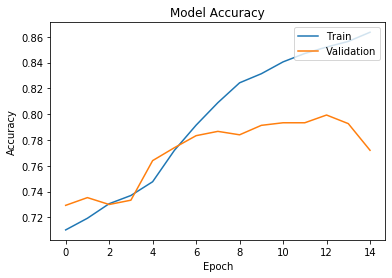

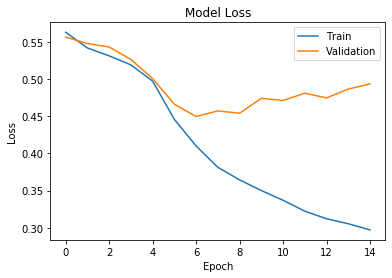

In [16]:
plot_model_training(hist)

In [22]:
model_cnn = model

In [147]:
k = model_cnn.predict([sent1_data_test, sent2_data_test])

In [148]:
result = convert_prob(k)

In [149]:
prec, rec, f1_s,acc =  evaluate_model(result, test_ann['entailment_encoded'])

In [150]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 score: "+ str(f1_s))
print("Accuracy: "+ str(acc*100)+"%")

Precision: 0.6674387819852599
Recall: 0.6687639537243759
F1 score: 0.6671298454580787
Accuracy: 66.87639537243759%


In [151]:
cnn_entailment = map_entailment(lbl_enc, result, test)

In [152]:
output_csv(cnn_entailment, "entailment_relatedness/entailment/siames_cnn_entailment.csv", index = False)

### GRU

In [30]:
import tensorflow as tf

In [31]:
m1 = models.models(embedding_dim,
                   NUM_WORDS, 
                   embedding_weights,
                   max_seq_length,
                  dropout=.1)

In [32]:
model = m1.GRU_tf()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         692100    
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1083600   
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 1,956,903
Trainable params: 1,956,903
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
hist = model.fit([sent1_data, sent2_data], labels, batch_size = batch_size, 
                 epochs = 5,
                 validation_data = ([sent1_data_trial, sent2_data_trial], labels2))

Train on 4500 samples, validate on 500 samples
Epoch 1/5
4500/4500 [==============================] - 71s 16ms/sample - loss: 0.9468 - accuracy: 0.5620 - val_loss: 0.8798 - val_accuracy: 0.5860
Epoch 2/5
4500/4500 [==============================] - 69s 15ms/sample - loss: 0.8805 - accuracy: 0.5773 - val_loss: 0.9044 - val_accuracy: 0.5660
Epoch 3/5
4500/4500 [==============================] - 64s 14ms/sample - loss: 0.8348 - accuracy: 0.5804 - val_loss: 0.9143 - val_accuracy: 0.5720
Epoch 4/5
4500/4500 [==============================] - 63s 14ms/sample - loss: 0.7720 - accuracy: 0.5824 - val_loss: 1.0481 - val_accuracy: 0.5840
Epoch 5/5
4500/4500 [==============================] - 66s 15ms/sample - loss: 0.7209 - accuracy: 0.5802 - val_loss: 1.1604 - val_accuracy: 0.5760


#### Model Evaluation

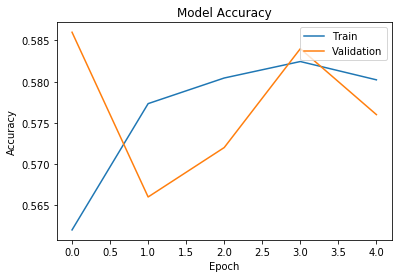

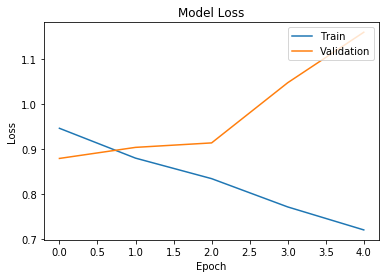

In [34]:
plot_model_training(hist)

In [40]:
model_gru = model

In [63]:
k = model_gru.predict([sent1_data_test, sent2_data_test])

In [64]:
result = convert_prob(k)

In [65]:
prec, rec, f1_score, acc = evaluate_model(test_ann['entailment_encoded'], result)

C:\Users\hkpat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hkpat\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 score: "+ str(f1_s))
print("Accuracy: "+ str(acc*100)+"%")

Precision: 0.41847040350134174
Recall: 0.5847371625735742
F1 score: 0.5666606408744548
Accuracy: 58.473716257357424%


In [67]:
gru_entailment = map_entailment(lbl_enc, result, test)

In [72]:
output_csv(gru_entailment, "entailment_relatedness/entailment/gru_entailment.csv", index = False)

### BiDirectional LSTM

In [121]:
import models.models as models
m1 = models.models(embedding_dim,
                   NUM_WORDS, 
                   embedding_weights,
                   max_seq_length*2
                  )

In [122]:
model = m1.lstm_bi()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 64, 300)      692100      main_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 300)      0           embedding_14[0][0]               
__________________________________________________________________________________________________
lstm_fwd (LSTM)                 (None, 64, 125)      213000      dropout[0][0]                    
___________________________________________________________________________________________

C:\Users\hkpat\Masters\NLP\Assignment2_final\submission\models\models.py:276: UserWarning: Update your `Model` call to the Keras 2 API: `Model([<tf.Tenso..., outputs=Tensor("de...)`
  model = Model([main_input], output=out)


In [123]:
sent = np.concatenate((sent1_data, sent2_data),axis= 1)

In [124]:
sent_trial = np.concatenate((sent1_data_trial, sent2_data_trial), axis = 1)

In [125]:
hist = model.fit(sent, labels, batch_size = 32, 
                 epochs = 10,
                 validation_data = (sent_trial, labels2))

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 20s 4ms/step - loss: 0.5422 - acc: 0.7093 - val_loss: 0.5014 - val_acc: 0.7340
Epoch 2/10
4500/4500 [==============================] - 20s 5ms/step - loss: 0.4781 - acc: 0.7459 - val_loss: 0.4846 - val_acc: 0.7280
Epoch 3/10
4500/4500 [==============================] - 20s 4ms/step - loss: 0.4516 - acc: 0.7620 - val_loss: 0.4811 - val_acc: 0.7387
Epoch 4/10
4500/4500 [==============================] - 20s 5ms/step - loss: 0.4289 - acc: 0.7788 - val_loss: 0.4941 - val_acc: 0.7420
Epoch 5/10
4500/4500 [==============================] - 20s 4ms/step - loss: 0.4114 - acc: 0.7901 - val_loss: 0.4988 - val_acc: 0.7373
Epoch 6/10
4500/4500 [==============================] - 20s 4ms/step - loss: 0.3957 - acc: 0.8020 - val_loss: 0.5403 - val_acc: 0.7320
Epoch 7/10
4500/4500 [==============================] - 20s 4ms/step - loss: 0.3744 - acc: 0.8194 - val_loss: 0.5463 - val_acc: 0.7127
Epoch 8/

#### Model evaluation

In [126]:
bilstm_model = model

In [127]:
sent_test = np.concatenate((sent1_data_test, sent2_data_test), axis =1)

In [129]:
k= bilstm_model.predict(sent_test)

In [130]:
result = convert_prob(k)

In [131]:
prec, rec, f1_s, acc = evaluate_model(list(test_ann['entailment_encoded']), list(predicted_val))

In [132]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 score: "+ str(f1_s))
print("Accuracy: "+ str(acc*100)+"%")

Precision: 0.6234360088659568
Recall: 0.6021920032474122
F1 score: 0.5282245863020105
Accuracy: 60.219200324741216%


In [136]:
bilstm_entailment = map_entailment(lbl_enc, result, test)

In [135]:
output_csv(bilstm_entailment, "entailment_relatedness/entailment/bilstm_entailment.csv", index = False)

###  CNN-2

In [74]:
## Simple Neural network
left_input= Input(shape = (max_seq_length,))
right_input = Input(shape = (max_seq_length,))

embedding_layer = Embedding(
        len(embedding_weights),
        embedding_dim,
        weights = [embedding_weights],
        input_length = max_seq_length,
        trainable = False)
x = embedding_layer(left_input)
x = Conv1D(16,3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(120, activation='relu')(x)

y = embedding_layer(right_input)
y  = Conv1D(16,3)(y)
y = GlobalMaxPooling1D()(y)
y = Dense(120, activation='relu')(y)
l1_norm = lambda x: 1 - K.abs(x[0] - x[1])
merged = layers.Lambda(function=l1_norm, output_shape=lambda x: x[0], 
                               name='L1_distance')([x, y])
predictions = layers.Dense(3, activation='sigmoid', name='Similarity_layer')(merged)

In [76]:
model = Model([left_input, right_input], predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
hist = model.fit([sent1_data, sent2_data], labels, batch_size = batch_size, 
                 epochs = 7,
                 validation_data = ([sent1_data_trial, sent2_data_trial], labels2))

Train on 4500 samples, validate on 500 samples
Epoch 1/7
4500/4500 [==============================] - 2s 413us/step - loss: 0.8394 - accuracy: 0.5782 - val_loss: 0.7541 - val_accuracy: 0.6080
Epoch 2/7
4500/4500 [==============================] - 2s 366us/step - loss: 0.7181 - accuracy: 0.6247 - val_loss: 0.7303 - val_accuracy: 0.6240
Epoch 3/7
4500/4500 [==============================] - 3s 594us/step - loss: 0.6749 - accuracy: 0.6396 - val_loss: 0.7576 - val_accuracy: 0.6340
Epoch 4/7
4500/4500 [==============================] - 3s 633us/step - loss: 0.6310 - accuracy: 0.6580 - val_loss: 0.7314 - val_accuracy: 0.6300
Epoch 5/7
4500/4500 [==============================] - 3s 666us/step - loss: 0.5897 - accuracy: 0.7018 - val_loss: 0.7846 - val_accuracy: 0.6120
Epoch 6/7
4500/4500 [==============================] - 3s 625us/step - loss: 0.5302 - accuracy: 0.7309 - val_loss: 0.8215 - val_accuracy: 0.6080
Epoch 7/7
4500/4500 [==============================] - 3s 654us/step - loss: 0.4889

#### Model evaluation

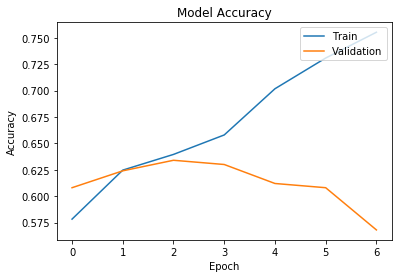

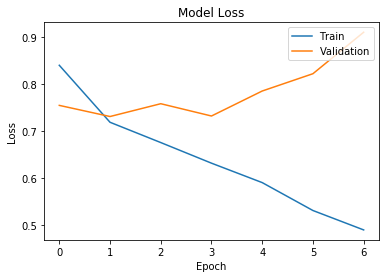

In [81]:
plot_model_training(hist)

In [82]:
k= model.predict([sent1_data_test, sent2_data_test])

In [83]:
predicted_val = convert_prob(k)

In [84]:
prec, rec, f1_s, acc = evaluate_model(list(test_ann['entailment_encoded']), list(predicted_val))

In [86]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 score: "+ str(f1_s))
print("Accuracy: "+ str(acc*100)+"%")

Precision: 0.5810059493259278
Recall: 0.5571341587172721
F1 score: 0.5600149457848421
Accuracy: 55.713415871727214%


### Deep RNN

In [95]:
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import concatenate, Dropout, BatchNormalization

In [139]:
input_1 = Input(shape=(max_seq_length,))
input_2 = Input(shape=(max_seq_length,))

left_input = Embedding(input_dim=NUM_WORDS,
               output_dim=embedding_dim,
               weights=[embedding_weights],
               input_length=max_seq_length,
               trainable=False)(input_1)
left_input = TimeDistributed(Dense(300, activation='relu'))(left_input)
left_input = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(left_input)

right_input = Embedding(input_dim=NUM_WORDS,
               output_dim=300,
               weights=[embedding_weights],
               input_length=max_seq_length,
               trainable=False)(input_2)
right_input = TimeDistributed(Dense(300, activation='relu'))(right_input)
right_input = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(right_input)

x = concatenate([left_input, right_input])
x = Dense(200, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)

out = Dense(3, activation='sigmoid')(x)

model = Model(inputs=[input_1, input_2], outputs=out)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [140]:
hist = model.fit([sent1_data, sent2_data], labels, batch_size = 32, 
                 epochs = 10,
                 validation_data = ([sent1_data_trial, sent2_data_trial], labels2))

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 3s 633us/step - loss: 0.7065 - accuracy: 0.5999 - val_loss: 0.5549 - val_accuracy: 0.7227
Epoch 2/10
4500/4500 [==============================] - 3s 742us/step - loss: 0.5670 - accuracy: 0.6953 - val_loss: 0.5213 - val_accuracy: 0.7260
Epoch 3/10
4500/4500 [==============================] - 3s 777us/step - loss: 0.5229 - accuracy: 0.7107 - val_loss: 0.5104 - val_accuracy: 0.7440
Epoch 4/10
4500/4500 [==============================] - 3s 775us/step - loss: 0.4950 - accuracy: 0.7303 - val_loss: 0.4883 - val_accuracy: 0.7267
Epoch 5/10
4500/4500 [==============================] - 3s 738us/step - loss: 0.4774 - accuracy: 0.7364 - val_loss: 0.5284 - val_accuracy: 0.7213
Epoch 6/10
4500/4500 [==============================] - 4s 844us/step - loss: 0.4449 - accuracy: 0.7647 - val_loss: 0.5216 - val_accuracy: 0.6900
Epoch 7/10
4500/4500 [==============================] - 4s 792us/step - loss:

#### Model evaluation

In [141]:
k= model.predict([sent1_data_test, sent2_data_test])

In [142]:
result = convert_prob(k)

In [143]:
prec, rec, f1_s, acc = evaluate_model(list(test_ann['entailment_encoded']), list(predicted_val))

In [144]:
print("Precision: "+ str(prec))
print("Recall: "+ str(rec))
print("F1 score: "+ str(f1_s))
print("Accuracy: "+ str(acc*100)+"%")

Precision: 0.6234360088659568
Recall: 0.6021920032474122
F1 score: 0.5282245863020105
Accuracy: 60.219200324741216%


In [145]:
deeprnn_entailment = map_entailment(lbl_enc, result, test)

C:\Users\hkpat\Masters\NLP\Assignment2_final\submission\functions\data_manipulation.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['entailment_judgment'] =  entailment_result


In [146]:
output_csv(bilstm_entailment, "entailment_relatedness/entailment/deeprnn_entailment.csv", index = False)